In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
from fastai.conv_learner import *
from fastai.dataset import *
import gzip
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import json, pdb
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects

from MyUtils import LR_Scheduler

In [3]:
PATH = Path('data/lsun/')
IMG_PATH = PATH/'bedroom'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
files = PATH.glob('bedroom/**/*.jpg')
with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(IMG_PATH)}, 0\n')

In [5]:
CSV_PATH = PATH/'files_sample.csv'

In [6]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files:
        if random.random()<0.1: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [7]:
# standard convolution
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [8]:
# Descriminator
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0
        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize, cndf = isize/2, ndf
        self.extra = nn.Sequential(*[
            ConvBlock(cndf, cndf, 3, 1) for t in range(n_extra_layers)
        ])
        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /=2
        self.pyramid = nn.Sequential(*pyr_layers)
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [9]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [10]:
# Generator
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0
        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]
        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2
        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)
    def forward(self, input): return F.tanh(self.features(input))
        

In [11]:
bs, sz, nz = 64, 64, 100

In [12]:
tfms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [13]:
class custom_data(Dataset):
    def __init__(self, label, tfms):
        super().__init__()
        self.label = pd.read_csv(label)
        self.tfms = tfms
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        img_name = self.label.loc[index][0]
        img = Image.open(IMG_PATH/img_name)
        if tfms is not None:
            img = self.tfms(img)
        return img

In [14]:
trn = custom_data(CSV_PATH, tfms)
trn = DataLoader(trn, bs, shuffle=False)

In [15]:
x = trn.__iter__().__next__()


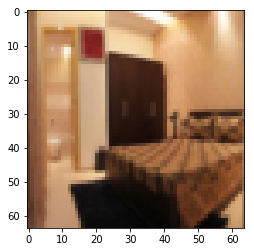

In [16]:
plt.imshow(x[0].permute([1,2,0]));

In [17]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [18]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

In [19]:
preds = netG(create_noise(4))
preds.type

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


<function Tensor.type>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


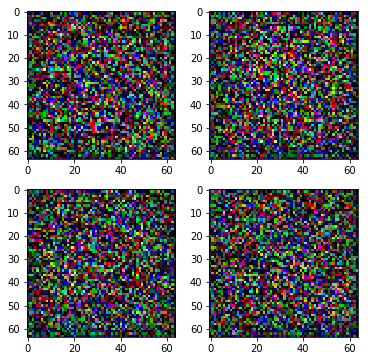

In [20]:
fig, axes = plt.subplots(2,2,figsize=(6,6))
for i, ax in enumerate(axes.flat): ax.imshow(to_np(preds[i].permute([1,2,0])))

In [21]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [22]:
optimizerD = optim.RMSprop(netD.parameters(), lr=1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-4)

In [23]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(trn)
        i, n = 0, len(trn)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations<25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter))
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    netD.zero_grad()
                    lossD = real_loss - fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()
                
                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [24]:
train(5, False)

  0%|          | 1/475 [00:00<01:36,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  0%|          | 2/475 [00:00<02:58,  2.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 3/475 [00:01<03:49,  2.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 4/475 [00:02<04:16,  1.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 5/475 [00:03<05:36,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|▏         | 6/475 [00:04<05:43,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|▏         | 7/475 [00:05<06:04,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 8/475 [00:05<05:55,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 9/475 [00:06<06:00,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 10/475 [00:07<06:16,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 11/475 [00:08<06:14,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 12/475 [00:09<05:46,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 13/475 [00:09<05:33,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 14/475 [00:10<05:32,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 15/475 [00:11<06:07,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 16/475 [00:12<06:00,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▎         | 17/475 [00:12<05:49,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 18/475 [00:13<05:35,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 19/475 [00:14<05:47,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 20/475 [00:15<05:46,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 21/475 [00:15<05:19,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 22/475 [00:16<05:26,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 23/475 [00:17<05:46,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 24/475 [00:18<05:44,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 25/475 [00:18<05:36,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 26/475 [00:19<05:36,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 27/475 [00:20<05:15,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 28/475 [00:20<05:01,  1.48it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 29/475 [00:21<05:21,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▋         | 30/475 [00:22<04:53,  1.51it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 31/475 [00:22<05:09,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 32/475 [00:23<05:23,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 33/475 [00:24<05:25,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 34/475 [00:25<05:26,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 35/475 [00:26<05:42,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 36/475 [00:26<05:31,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 37/475 [00:27<05:33,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 38/475 [00:28<05:09,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 39/475 [00:28<05:23,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 40/475 [00:29<05:34,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▊         | 41/475 [00:30<05:47,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 42/475 [00:31<05:37,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 43/475 [00:32<05:24,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 44/475 [00:32<05:16,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 45/475 [00:33<05:17,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|▉         | 46/475 [00:34<05:05,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|▉         | 47/475 [00:34<05:03,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|█         | 48/475 [00:35<05:19,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|█         | 49/475 [00:36<05:00,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 50/475 [00:37<05:19,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 51/475 [00:37<05:21,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 52/475 [00:38<05:39,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 53/475 [00:39<05:45,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█▏        | 54/475 [00:40<05:58,  1.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 55/475 [00:41<05:45,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 56/475 [00:42<05:52,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 57/475 [00:42<05:19,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 58/475 [00:43<05:17,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 59/475 [00:44<05:34,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 60/475 [00:45<05:26,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 61/475 [00:45<05:03,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 62/475 [00:46<04:57,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 63/475 [00:47<04:47,  1.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 64/475 [00:48<05:20,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▎        | 65/475 [00:49<05:29,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 66/475 [00:49<05:20,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 67/475 [00:50<04:42,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 68/475 [00:51<05:03,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 69/475 [00:51<04:48,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 70/475 [00:52<05:01,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 71/475 [00:53<04:44,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▌        | 72/475 [00:54<05:25,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▌        | 73/475 [00:54<05:19,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 74/475 [00:55<05:01,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 75/475 [00:56<05:21,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 76/475 [00:57<05:22,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 77/475 [00:58<05:28,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▋        | 78/475 [00:58<05:07,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 79/475 [00:59<05:29,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 80/475 [01:00<05:09,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 81/475 [01:01<05:08,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 82/475 [01:01<04:52,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 83/475 [01:02<04:58,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 84/475 [01:03<04:47,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 85/475 [01:04<04:58,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 86/475 [01:04<04:16,  1.52it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 87/475 [01:05<04:20,  1.49it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▊        | 88/475 [01:06<04:21,  1.48it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▊        | 89/475 [01:06<04:46,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 90/475 [01:07<04:47,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 91/475 [01:08<04:49,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 92/475 [01:09<05:07,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|█▉        | 93/475 [01:10<05:19,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|█▉        | 94/475 [01:11<05:05,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 95/475 [01:11<04:33,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 96/475 [01:12<04:31,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 97/475 [01:13<04:57,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 98/475 [01:13<04:52,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 99/475 [01:14<05:04,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 100/475 [01:15<04:49,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██▏       | 101/475 [01:16<04:46,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██▏       | 102/475 [01:17<05:08,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 103/475 [01:17<04:45,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 104/475 [01:18<04:49,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 105/475 [01:19<04:31,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 106/475 [01:20<04:36,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 107/475 [01:20<04:07,  1.48it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 108/475 [01:21<04:21,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 109/475 [01:22<04:27,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 110/475 [01:23<05:05,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 111/475 [01:24<04:58,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▎       | 112/475 [01:24<04:44,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 113/475 [01:25<04:33,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 114/475 [01:25<04:06,  1.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 115/475 [01:26<04:20,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 116/475 [01:27<04:21,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 117/475 [01:28<04:54,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 118/475 [01:29<04:34,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 119/475 [01:30<04:58,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 120/475 [01:31<04:57,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 121/475 [01:31<04:50,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 122/475 [01:32<04:37,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 123/475 [01:33<04:31,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 124/475 [01:34<04:38,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▋       | 125/475 [01:34<04:25,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 126/475 [01:35<04:52,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 127/475 [01:36<04:35,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 128/475 [01:37<04:55,  1.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 129/475 [01:38<04:36,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 130/475 [01:38<04:23,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 131/475 [01:39<04:38,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 132/475 [01:40<04:39,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 133/475 [01:41<04:28,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 134/475 [01:41<04:09,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 135/475 [01:42<04:07,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▊       | 136/475 [01:43<04:33,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 137/475 [01:44<04:44,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 138/475 [01:45<04:28,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 139/475 [01:46<04:32,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 140/475 [01:46<03:56,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|██▉       | 141/475 [01:47<04:16,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|██▉       | 142/475 [01:48<04:06,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|███       | 143/475 [01:48<04:03,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|███       | 144/475 [01:49<04:02,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 145/475 [01:50<04:08,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 146/475 [01:51<04:01,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 147/475 [01:51<03:54,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 148/475 [01:52<04:04,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███▏      | 149/475 [01:53<04:14,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 150/475 [01:54<04:08,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 151/475 [01:55<04:24,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 152/475 [01:55<04:10,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 153/475 [01:56<04:12,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 154/475 [01:57<04:10,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 155/475 [01:58<04:25,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 156/475 [01:58<04:06,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 157/475 [01:59<04:11,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 158/475 [02:00<04:20,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 159/475 [02:01<04:20,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▎      | 160/475 [02:02<04:25,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 161/475 [02:03<04:43,  1.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 162/475 [02:04<04:34,  1.14it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 163/475 [02:05<04:40,  1.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 164/475 [02:05<04:01,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 165/475 [02:06<04:15,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 166/475 [02:07<04:08,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▌      | 167/475 [02:08<04:21,  1.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▌      | 168/475 [02:08<03:59,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 169/475 [02:09<04:04,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 170/475 [02:10<04:02,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 171/475 [02:11<03:48,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 172/475 [02:11<03:27,  1.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▋      | 173/475 [02:12<03:37,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 174/475 [02:13<03:45,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 175/475 [02:14<04:01,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 176/475 [02:14<03:48,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 177/475 [02:15<03:41,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 178/475 [02:16<03:38,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 179/475 [02:17<03:50,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 180/475 [02:17<03:26,  1.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 181/475 [02:18<03:39,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 182/475 [02:19<03:36,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▊      | 183/475 [02:20<03:44,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▊      | 184/475 [02:20<03:35,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 185/475 [02:21<03:47,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 186/475 [02:22<03:45,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 187/475 [02:23<03:49,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|███▉      | 188/475 [02:24<03:36,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|███▉      | 189/475 [02:25<03:56,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 190/475 [02:25<03:58,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 191/475 [02:26<03:31,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 192/475 [02:27<03:47,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 193/475 [02:28<03:36,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 194/475 [02:28<03:24,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 195/475 [02:29<03:03,  1.52it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████▏     | 196/475 [02:29<03:11,  1.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████▏     | 197/475 [02:30<03:04,  1.50it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 198/475 [02:31<03:16,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 199/475 [02:31<03:09,  1.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 200/475 [02:32<03:32,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 201/475 [02:33<03:18,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 202/475 [02:34<03:47,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 203/475 [02:35<03:55,  1.15it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 204/475 [02:36<03:42,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 205/475 [02:37<03:43,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 206/475 [02:37<03:25,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▎     | 207/475 [02:38<03:38,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 208/475 [02:39<03:49,  1.16it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 209/475 [02:40<03:30,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 210/475 [02:40<03:15,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 211/475 [02:41<03:13,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 212/475 [02:42<03:10,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 213/475 [02:43<03:12,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 214/475 [02:44<03:26,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 215/475 [02:44<03:24,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 216/475 [02:45<03:23,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 217/475 [02:46<03:23,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 218/475 [02:47<03:23,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 219/475 [02:47<03:00,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▋     | 220/475 [02:48<02:59,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 221/475 [02:48<02:47,  1.52it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 222/475 [02:49<03:03,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 223/475 [02:50<03:05,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 224/475 [02:51<03:11,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 225/475 [02:52<03:19,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 226/475 [02:53<03:30,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 227/475 [02:54<03:32,  1.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 228/475 [02:54<03:14,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 229/475 [02:55<03:15,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 230/475 [02:56<03:10,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▊     | 231/475 [02:57<03:17,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 232/475 [02:57<03:02,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 233/475 [02:58<03:09,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 234/475 [02:59<03:00,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 235/475 [03:00<03:13,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|████▉     | 236/475 [03:00<02:51,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|████▉     | 237/475 [03:01<03:11,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|█████     | 238/475 [03:02<02:55,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|█████     | 239/475 [03:03<02:55,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 240/475 [03:03<02:37,  1.49it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 241/475 [03:04<02:36,  1.50it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 242/475 [03:05<02:42,  1.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 243/475 [03:05<02:35,  1.49it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████▏    | 244/475 [03:06<02:59,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 245/475 [03:07<03:01,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 246/475 [03:08<03:06,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 247/475 [03:08<02:41,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 248/475 [03:09<02:33,  1.48it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 249/475 [03:09<02:18,  1.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 250/475 [03:10<02:32,  1.48it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 251/475 [03:11<02:28,  1.51it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 252/475 [03:12<02:36,  1.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 253/475 [03:12<02:32,  1.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 254/475 [03:13<02:33,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▎    | 255/475 [03:13<02:17,  1.60it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 256/475 [03:14<02:28,  1.48it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 257/475 [03:15<02:24,  1.50it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 258/475 [03:16<03:03,  1.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 259/475 [03:17<02:44,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 260/475 [03:17<02:43,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 261/475 [03:18<02:43,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▌    | 262/475 [03:19<02:38,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▌    | 263/475 [03:20<02:26,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 264/475 [03:20<02:35,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 265/475 [03:21<02:30,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 266/475 [03:22<02:37,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 267/475 [03:23<02:36,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▋    | 268/475 [03:23<02:34,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 269/475 [03:24<02:39,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 270/475 [03:25<02:46,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 271/475 [03:26<02:37,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 272/475 [03:26<02:21,  1.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 273/475 [03:27<02:17,  1.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 274/475 [03:28<02:18,  1.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 275/475 [03:29<02:32,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 276/475 [03:30<02:44,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 277/475 [03:30<02:35,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 278/475 [03:31<02:34,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 279/475 [03:32<02:31,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 280/475 [03:33<02:35,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 281/475 [03:34<02:46,  1.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 282/475 [03:35<02:48,  1.15it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|█████▉    | 283/475 [03:35<02:40,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|█████▉    | 284/475 [03:36<02:38,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 285/475 [03:37<02:38,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 286/475 [03:38<02:47,  1.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 287/475 [03:39<02:31,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 288/475 [03:39<02:35,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 289/475 [03:40<02:26,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 290/475 [03:41<02:27,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████▏   | 291/475 [03:42<02:18,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████▏   | 292/475 [03:42<02:15,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 293/475 [03:43<02:14,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 294/475 [03:44<02:17,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 295/475 [03:45<02:11,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 296/475 [03:45<02:08,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 297/475 [03:46<01:57,  1.52it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 298/475 [03:46<01:57,  1.51it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 299/475 [03:47<01:47,  1.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 300/475 [03:48<01:53,  1.54it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 301/475 [03:48<01:54,  1.52it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▎   | 302/475 [03:49<02:13,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 303/475 [03:50<02:00,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 304/475 [03:51<02:11,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 305/475 [03:52<02:09,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 306/475 [03:52<02:12,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▍   | 307/475 [03:53<02:08,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▍   | 308/475 [03:54<02:04,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 309/475 [03:55<02:12,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 310/475 [03:55<02:03,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 311/475 [03:56<01:59,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 312/475 [03:57<01:59,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 313/475 [03:58<01:57,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 314/475 [03:58<02:03,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▋   | 315/475 [03:59<01:55,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 316/475 [04:00<01:55,  1.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 317/475 [04:00<01:50,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 318/475 [04:01<01:57,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 319/475 [04:02<01:52,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 320/475 [04:03<01:55,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 321/475 [04:03<01:51,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 322/475 [04:04<01:40,  1.52it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 323/475 [04:05<01:46,  1.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 324/475 [04:05<01:48,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 325/475 [04:06<01:51,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▊   | 326/475 [04:07<01:47,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 327/475 [04:08<01:46,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 328/475 [04:08<01:44,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 329/475 [04:09<01:53,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 330/475 [04:10<01:52,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|██████▉   | 331/475 [04:11<01:43,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|██████▉   | 332/475 [04:12<01:58,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|███████   | 333/475 [04:12<01:47,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|███████   | 334/475 [04:13<01:37,  1.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 335/475 [04:14<01:45,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 336/475 [04:14<01:36,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 337/475 [04:15<01:35,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 338/475 [04:16<01:37,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████▏  | 339/475 [04:16<01:35,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 340/475 [04:17<01:33,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 341/475 [04:18<01:34,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 342/475 [04:18<01:30,  1.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 343/475 [04:19<01:24,  1.56it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 344/475 [04:20<01:33,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 345/475 [04:21<01:39,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 346/475 [04:22<01:43,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 347/475 [04:23<01:55,  1.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 348/475 [04:24<01:48,  1.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 349/475 [04:24<01:45,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▎  | 350/475 [04:25<01:40,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 351/475 [04:26<01:40,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 352/475 [04:26<01:28,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 353/475 [04:27<01:34,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 354/475 [04:28<01:34,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 355/475 [04:29<01:24,  1.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 356/475 [04:29<01:29,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 357/475 [04:30<01:24,  1.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 358/475 [04:31<01:29,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 359/475 [04:32<01:35,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 360/475 [04:33<01:38,  1.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 361/475 [04:33<01:28,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 362/475 [04:34<01:27,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▋  | 363/475 [04:35<01:31,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 364/475 [04:36<01:35,  1.16it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 365/475 [04:37<01:30,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 366/475 [04:38<01:32,  1.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 367/475 [04:39<01:31,  1.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 368/475 [04:39<01:27,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 369/475 [04:40<01:15,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 370/475 [04:41<01:18,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 371/475 [04:41<01:12,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 372/475 [04:42<01:18,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▊  | 373/475 [04:43<01:10,  1.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▊  | 374/475 [04:43<01:11,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 375/475 [04:44<01:08,  1.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 376/475 [04:45<01:13,  1.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 377/475 [04:46<01:13,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|███████▉  | 378/475 [04:47<01:18,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|███████▉  | 379/475 [04:47<01:11,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 380/475 [04:48<01:12,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 381/475 [04:49<01:04,  1.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 382/475 [04:49<01:05,  1.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 383/475 [04:50<01:01,  1.49it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 384/475 [04:51<01:05,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 385/475 [04:52<01:07,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████▏ | 386/475 [04:52<01:07,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████▏ | 387/475 [04:53<01:07,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 388/475 [04:54<01:05,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 389/475 [04:55<01:08,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 390/475 [04:56<01:09,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 391/475 [04:56<01:09,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 392/475 [04:57<01:06,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 393/475 [04:58<01:02,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 394/475 [04:59<01:02,  1.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 395/475 [04:59<01:03,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 396/475 [05:00<01:02,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▎ | 397/475 [05:01<01:03,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 398/475 [05:02<01:00,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 399/475 [05:02<00:56,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 400/475 [05:03<00:58,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 401/475 [05:04<00:56,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 402/475 [05:05<00:55,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 403/475 [05:06<00:58,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 404/475 [05:06<00:56,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 405/475 [05:07<00:57,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 406/475 [05:08<00:55,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 407/475 [05:09<00:53,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 408/475 [05:10<00:51,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 409/475 [05:10<00:49,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▋ | 410/475 [05:11<00:52,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 411/475 [05:12<00:50,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 412/475 [05:13<00:46,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 413/475 [05:14<00:49,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 414/475 [05:14<00:48,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 415/475 [05:15<00:43,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 416/475 [05:16<00:42,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 417/475 [05:16<00:40,  1.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 418/475 [05:17<00:47,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 419/475 [05:18<00:43,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 420/475 [05:19<00:42,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▊ | 421/475 [05:19<00:37,  1.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 422/475 [05:20<00:42,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 423/475 [05:21<00:43,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 424/475 [05:22<00:42,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 425/475 [05:23<00:41,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|████████▉ | 426/475 [05:24<00:36,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|████████▉ | 427/475 [05:24<00:37,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|█████████ | 428/475 [05:25<00:33,  1.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|█████████ | 429/475 [05:26<00:34,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 430/475 [05:27<00:33,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 431/475 [05:27<00:33,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 432/475 [05:28<00:31,  1.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 433/475 [05:29<00:29,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████▏| 434/475 [05:29<00:30,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 435/475 [05:30<00:30,  1.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 436/475 [05:31<00:32,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 437/475 [05:32<00:31,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 438/475 [05:33<00:27,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 439/475 [05:33<00:26,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 440/475 [05:34<00:26,  1.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 441/475 [05:35<00:28,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 442/475 [05:36<00:26,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 443/475 [05:37<00:25,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 444/475 [05:37<00:24,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▎| 445/475 [05:38<00:23,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 446/475 [05:39<00:24,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 447/475 [05:40<00:22,  1.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 448/475 [05:41<00:21,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 449/475 [05:42<00:22,  1.14it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 450/475 [05:43<00:22,  1.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 451/475 [05:44<00:21,  1.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▌| 452/475 [05:44<00:19,  1.16it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▌| 453/475 [05:45<00:18,  1.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 454/475 [05:46<00:17,  1.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 455/475 [05:47<00:17,  1.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 456/475 [05:47<00:15,  1.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 457/475 [05:48<00:13,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▋| 458/475 [05:49<00:12,  1.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 459/475 [05:49<00:11,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 460/475 [05:50<00:10,  1.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 461/475 [05:51<00:10,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 462/475 [05:52<00:10,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 463/475 [05:53<00:09,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 464/475 [05:54<00:08,  1.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 465/475 [05:54<00:07,  1.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 466/475 [05:55<00:07,  1.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 467/475 [05:56<00:05,  1.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▊| 468/475 [05:57<00:05,  1.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▊| 469/475 [05:57<00:04,  1.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 470/475 [05:59<00:04,  1.15it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 471/475 [05:59<00:03,  1.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 472/475 [06:00<00:02,  1.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|█████████▉| 473/475 [06:01<00:01,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|█████████▉| 474/475 [06:02<00:00,  1.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|██████████| 475/475 [06:02<00:00,  1.48it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



Loss_D [-1.54459]; Loss_G [0.76393]; D_real [-0.79506]; Loss_D_fake [0.74953]
  0%|          | 2/475 [00:00<01:33,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 3/475 [00:00<01:32,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 5/475 [00:00<01:31,  5.14it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|▏         | 6/475 [00:01<01:43,  4.51it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 9/475 [00:01<01:34,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 10/475 [00:02<01:33,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 11/475 [00:02<01:45,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 13/475 [00:02<01:37,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 15/475 [00:03<01:33,  4.90it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 16/475 [00:03<01:45,  4.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 19/475 [00:03<01:33,  4.89it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 20/475 [00:04<01:31,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 22/475 [00:04<01:38,  4.61it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 23/475 [00:04<01:34,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 25/475 [00:05<01:30,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 26/475 [00:05<01:41,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 29/475 [00:06<01:30,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▋         | 30/475 [00:06<01:29,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 31/475 [00:06<01:41,  4.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 33/475 [00:06<01:32,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 35/475 [00:07<01:28,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 37/475 [00:07<01:34,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 39/475 [00:08<01:28,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 40/475 [00:08<01:26,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▊         | 41/475 [00:08<01:38,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 43/475 [00:09<01:30,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 45/475 [00:09<01:26,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|▉         | 46/475 [00:09<01:37,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|█         | 49/475 [00:10<01:27,  4.86it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 50/475 [00:10<01:25,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 51/475 [00:10<01:36,  4.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 53/475 [00:11<01:28,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 55/475 [00:11<01:24,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 56/475 [00:11<01:35,  4.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 58/475 [00:12<01:28,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 60/475 [00:12<01:24,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 61/475 [00:12<01:34,  4.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 63/475 [00:13<01:27,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▎        | 65/475 [00:13<01:23,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 66/475 [00:14<01:33,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 68/475 [00:14<01:26,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 70/475 [00:14<01:22,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 71/475 [00:15<01:32,  4.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▌        | 73/475 [00:15<01:25,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 75/475 [00:15<01:20,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 76/475 [00:16<01:30,  4.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▋        | 78/475 [00:16<01:24,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 80/475 [00:16<01:19,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 82/475 [00:17<01:24,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 84/475 [00:17<01:19,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 85/475 [00:17<01:17,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 86/475 [00:18<01:27,  4.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▊        | 88/475 [00:18<01:20,  4.78it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 90/475 [00:19<01:17,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 91/475 [00:19<01:27,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|█▉        | 94/475 [00:19<01:17,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 95/475 [00:20<01:16,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 96/475 [00:20<01:26,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 99/475 [00:20<01:16,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 100/475 [00:21<01:14,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██▏       | 101/475 [00:21<01:24,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 103/475 [00:21<01:18,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 105/475 [00:22<01:14,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 107/475 [00:22<01:19,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 109/475 [00:23<01:14,  4.89it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 110/475 [00:23<01:13,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 111/475 [00:23<01:22,  4.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 113/475 [00:23<01:16,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 115/475 [00:24<01:12,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 117/475 [00:24<01:17,  4.61it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 119/475 [00:25<01:12,  4.90it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 120/475 [00:25<01:11,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 121/475 [00:25<01:20,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 123/475 [00:26<01:14,  4.75it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▋       | 125/475 [00:26<01:10,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 127/475 [00:26<01:15,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 128/475 [00:27<01:11,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 130/475 [00:27<01:08,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 132/475 [00:27<01:13,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 134/475 [00:28<01:08,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 135/475 [00:28<01:07,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 137/475 [00:29<01:12,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 139/475 [00:29<01:08,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 140/475 [00:29<01:06,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|██▉       | 142/475 [00:30<01:11,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|███       | 144/475 [00:30<01:07,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 145/475 [00:30<01:05,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 147/475 [00:31<01:10,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███▏      | 149/475 [00:31<01:05,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 150/475 [00:31<01:03,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 152/475 [00:32<01:08,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 153/475 [00:32<01:06,  4.86it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 155/475 [00:32<01:03,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 157/475 [00:33<01:08,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 158/475 [00:33<01:06,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▎      | 160/475 [00:33<01:02,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 162/475 [00:34<01:06,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 164/475 [00:34<01:02,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 165/475 [00:34<01:01,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▌      | 167/475 [00:35<01:06,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 169/475 [00:35<01:00,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 170/475 [00:35<00:59,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 171/475 [00:36<01:08,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 174/475 [00:36<01:01,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 175/475 [00:36<00:59,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 176/475 [00:37<01:07,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 179/475 [00:37<00:59,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 180/475 [00:37<00:58,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 182/475 [00:38<01:02,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▊      | 183/475 [00:38<01:00,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 185/475 [00:39<00:58,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 187/475 [00:39<01:01,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|███▉      | 189/475 [00:39<00:57,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 190/475 [00:40<00:56,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 192/475 [00:40<01:00,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 194/475 [00:40<00:56,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 195/475 [00:41<00:55,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████▏     | 197/475 [00:41<00:59,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 199/475 [00:41<00:55,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 200/475 [00:42<00:54,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 202/475 [00:42<00:57,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 204/475 [00:43<00:54,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 205/475 [00:43<00:53,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▎     | 207/475 [00:43<00:57,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 209/475 [00:44<00:53,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 210/475 [00:44<00:52,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 212/475 [00:44<00:56,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 214/475 [00:45<00:52,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 215/475 [00:45<00:51,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 216/475 [00:45<00:58,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 219/475 [00:46<00:51,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▋     | 220/475 [00:46<00:50,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 221/475 [00:46<00:57,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 224/475 [00:47<00:50,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 225/475 [00:47<00:49,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 227/475 [00:47<00:52,  4.74it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 229/475 [00:48<00:49,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 230/475 [00:48<00:48,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 232/475 [00:48<00:51,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 234/475 [00:49<00:48,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 235/475 [00:49<00:47,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|████▉     | 237/475 [00:49<00:50,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|█████     | 239/475 [00:50<00:47,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 240/475 [00:50<00:46,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 242/475 [00:50<00:50,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████▏    | 244/475 [00:51<00:46,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 245/475 [00:51<00:44,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 247/475 [00:52<00:48,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 249/475 [00:52<00:44,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 250/475 [00:52<00:44,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 252/475 [00:53<00:47,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 254/475 [00:53<00:44,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▎    | 255/475 [00:53<00:43,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 257/475 [00:54<00:46,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 259/475 [00:54<00:43,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 260/475 [00:54<00:42,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▌    | 262/475 [00:55<00:45,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 264/475 [00:55<00:42,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 265/475 [00:55<00:41,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 267/475 [00:56<00:44,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 269/475 [00:56<00:41,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 270/475 [00:56<00:40,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 272/475 [00:57<00:43,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 274/475 [00:57<00:40,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 275/475 [00:57<00:39,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 277/475 [00:58<00:42,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 278/475 [00:58<00:40,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 280/475 [00:58<00:38,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 282/475 [00:59<00:41,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|█████▉    | 284/475 [00:59<00:38,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 285/475 [00:59<00:37,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 287/475 [01:00<00:40,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 289/475 [01:00<00:37,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 290/475 [01:00<00:36,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████▏   | 292/475 [01:01<00:39,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 294/475 [01:01<00:36,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 295/475 [01:01<00:35,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 297/475 [01:02<00:38,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 299/475 [01:02<00:35,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 300/475 [01:03<00:34,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▎   | 302/475 [01:03<00:37,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 303/475 [01:03<00:35,  4.80it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 305/475 [01:04<00:33,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▍   | 307/475 [01:04<00:36,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 309/475 [01:04<00:33,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 310/475 [01:05<00:32,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 311/475 [01:05<00:37,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 313/475 [01:05<00:33,  4.78it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▋   | 315/475 [01:06<00:31,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 317/475 [01:06<00:33,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 319/475 [01:07<00:31,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 320/475 [01:07<00:30,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 322/475 [01:07<00:32,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 324/475 [01:08<00:30,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 325/475 [01:08<00:29,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 327/475 [01:08<00:31,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 329/475 [01:09<00:29,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 330/475 [01:09<00:28,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|██████▉   | 332/475 [01:09<00:30,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|███████   | 334/475 [01:10<00:28,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 335/475 [01:10<00:27,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 337/475 [01:10<00:29,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████▏  | 339/475 [01:11<00:27,  4.91it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 340/475 [01:11<00:27,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 342/475 [01:11<00:28,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 344/475 [01:12<00:26,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 345/475 [01:12<00:25,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 347/475 [01:12<00:27,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 349/475 [01:13<00:25,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▎  | 350/475 [01:13<00:24,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 352/475 [01:14<00:26,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 354/475 [01:14<00:24,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 355/475 [01:14<00:23,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 357/475 [01:15<00:25,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 359/475 [01:15<00:23,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 360/475 [01:15<00:22,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 362/475 [01:16<00:24,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 364/475 [01:16<00:22,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 365/475 [01:16<00:21,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 367/475 [01:17<00:23,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 369/475 [01:17<00:21,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 370/475 [01:17<00:20,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 372/475 [01:18<00:22,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▊  | 374/475 [01:18<00:20,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 375/475 [01:18<00:19,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 377/475 [01:19<00:20,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|███████▉  | 378/475 [01:19<00:19,  4.87it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 380/475 [01:19<00:18,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 382/475 [01:20<00:20,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 384/475 [01:20<00:18,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 385/475 [01:20<00:17,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████▏ | 387/475 [01:21<00:18,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 388/475 [01:21<00:18,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 390/475 [01:21<00:16,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 391/475 [01:22<00:19,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 394/475 [01:22<00:16,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 395/475 [01:22<00:16,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▎ | 397/475 [01:23<00:16,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 399/475 [01:23<00:15,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 400/475 [01:24<00:14,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 402/475 [01:24<00:15,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 403/475 [01:24<00:14,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 405/475 [01:25<00:13,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 407/475 [01:25<00:14,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 409/475 [01:25<00:13,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▋ | 410/475 [01:26<00:12,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 411/475 [01:26<00:14,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 413/475 [01:26<00:12,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 415/475 [01:27<00:11,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 417/475 [01:27<00:12,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 419/475 [01:28<00:11,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 420/475 [01:28<00:10,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 422/475 [01:28<00:11,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 424/475 [01:29<00:10,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 425/475 [01:29<00:09,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|████████▉ | 427/475 [01:29<00:10,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|█████████ | 429/475 [01:30<00:09,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 430/475 [01:30<00:08,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 431/475 [01:30<00:09,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████▏| 434/475 [01:31<00:08,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 435/475 [01:31<00:07,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 437/475 [01:31<00:08,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 439/475 [01:32<00:07,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 440/475 [01:32<00:06,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 441/475 [01:32<00:07,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 443/475 [01:33<00:06,  4.76it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▎| 445/475 [01:33<00:06,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 447/475 [01:33<00:06,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 449/475 [01:34<00:05,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 450/475 [01:34<00:04,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▌| 452/475 [01:34<00:04,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 454/475 [01:35<00:04,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 455/475 [01:35<00:03,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 457/475 [01:36<00:03,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 459/475 [01:36<00:03,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 460/475 [01:36<00:02,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 462/475 [01:37<00:02,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 464/475 [01:37<00:02,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 465/475 [01:37<00:01,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 466/475 [01:37<00:02,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▊| 469/475 [01:38<00:01,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 470/475 [01:38<00:00,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 471/475 [01:38<00:00,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|█████████▉| 474/475 [01:39<00:00,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|██████████| 475/475 [01:39<00:00,  5.59it/s]


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss_D [-1.53594]; Loss_G [0.74963]; D_real [-0.79992]; Loss_D_fake [0.73602]
  0%|          | 2/475 [00:00<01:30,  5.21it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 4/475 [00:00<01:29,  5.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 5/475 [00:00<01:29,  5.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|▏         | 7/475 [00:01<01:39,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 9/475 [00:01<01:32,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 10/475 [00:01<01:31,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 12/475 [00:02<01:38,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 14/475 [00:02<01:32,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 15/475 [00:03<01:30,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▎         | 17/475 [00:03<01:37,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 19/475 [00:03<01:31,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 20/475 [00:04<01:29,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 22/475 [00:04<01:35,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 24/475 [00:04<01:30,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 25/475 [00:05<01:28,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 27/475 [00:05<01:34,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 29/475 [00:05<01:28,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▋         | 30/475 [00:06<01:26,  5.14it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 31/475 [00:06<01:40,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 34/475 [00:07<01:29,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 35/475 [00:07<01:27,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 37/475 [00:07<01:33,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 39/475 [00:08<01:26,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 40/475 [00:08<01:25,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▊         | 41/475 [00:08<01:37,  4.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 43/475 [00:08<01:29,  4.80it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 45/475 [00:09<01:25,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|▉         | 47/475 [00:09<01:31,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|█         | 49/475 [00:10<01:25,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 50/475 [00:10<01:24,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 52/475 [00:10<01:31,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█▏        | 54/475 [00:11<01:24,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 55/475 [00:11<01:22,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 57/475 [00:11<01:29,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 59/475 [00:12<01:23,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 60/475 [00:12<01:21,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 62/475 [00:12<01:28,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 64/475 [00:13<01:23,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▎        | 65/475 [00:13<01:21,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 67/475 [00:13<01:27,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 69/475 [00:14<01:22,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 70/475 [00:14<01:20,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 71/475 [00:14<01:31,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 74/475 [00:15<01:20,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 75/475 [00:15<01:19,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 77/475 [00:16<01:25,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 79/475 [00:16<01:19,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 80/475 [00:16<01:18,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 82/475 [00:17<01:24,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 84/475 [00:17<01:18,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 85/475 [00:17<01:16,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 86/475 [00:17<01:27,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▊        | 89/475 [00:18<01:17,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 90/475 [00:18<01:15,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 91/475 [00:18<01:26,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|█▉        | 94/475 [00:19<01:16,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 95/475 [00:19<01:15,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 97/475 [00:20<01:21,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 99/475 [00:20<01:15,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 100/475 [00:20<01:14,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██▏       | 101/475 [00:21<01:24,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 104/475 [00:21<01:15,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 105/475 [00:21<01:13,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 107/475 [00:22<01:18,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 109/475 [00:22<01:14,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 110/475 [00:22<01:12,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▎       | 112/475 [00:23<01:17,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 113/475 [00:23<01:15,  4.78it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 115/475 [00:23<01:12,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 117/475 [00:24<01:17,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 118/475 [00:24<01:14,  4.81it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 120/475 [00:25<01:11,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 122/475 [00:25<01:16,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 123/475 [00:25<01:13,  4.79it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▋       | 125/475 [00:26<01:09,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 127/475 [00:26<01:14,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 128/475 [00:26<01:11,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 130/475 [00:27<01:09,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 132/475 [00:27<01:14,  4.61it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 134/475 [00:27<01:09,  4.91it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 135/475 [00:28<01:08,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 137/475 [00:28<01:12,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 139/475 [00:29<01:07,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 140/475 [00:29<01:05,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|██▉       | 141/475 [00:29<01:15,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|███       | 144/475 [00:30<01:06,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 145/475 [00:30<01:05,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 147/475 [00:30<01:10,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███▏      | 149/475 [00:31<01:04,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 150/475 [00:31<01:03,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 152/475 [00:31<01:08,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 153/475 [00:31<01:06,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 155/475 [00:32<01:04,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 157/475 [00:32<01:08,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 158/475 [00:33<01:06,  4.80it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▎      | 160/475 [00:33<01:02,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 162/475 [00:33<01:07,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 164/475 [00:34<01:02,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 165/475 [00:34<01:00,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 166/475 [00:34<01:09,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 169/475 [00:35<01:01,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 170/475 [00:35<01:00,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 171/475 [00:35<01:08,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 174/475 [00:36<01:00,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 175/475 [00:36<00:59,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 176/475 [00:36<01:07,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 179/475 [00:37<00:59,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 180/475 [00:37<00:58,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 182/475 [00:38<01:02,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▊      | 184/475 [00:38<00:58,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 185/475 [00:38<00:57,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 186/475 [00:38<01:05,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|███▉      | 189/475 [00:39<00:57,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 190/475 [00:39<00:56,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 192/475 [00:40<01:00,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 194/475 [00:40<00:56,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 195/475 [00:40<00:55,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████▏     | 196/475 [00:41<01:03,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 199/475 [00:41<00:55,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 200/475 [00:41<00:54,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 202/475 [00:42<00:58,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 204/475 [00:42<00:54,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 205/475 [00:42<00:53,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▎     | 207/475 [00:43<00:57,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 209/475 [00:43<00:53,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 210/475 [00:43<00:52,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 212/475 [00:44<00:56,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 213/475 [00:44<00:54,  4.78it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 215/475 [00:44<00:52,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 217/475 [00:45<00:55,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 219/475 [00:45<00:51,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▋     | 220/475 [00:46<00:50,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 222/475 [00:46<00:54,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 224/475 [00:46<00:50,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 225/475 [00:47<00:49,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 227/475 [00:47<00:52,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 229/475 [00:47<00:49,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 230/475 [00:48<00:48,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 232/475 [00:48<00:52,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 234/475 [00:48<00:48,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 235/475 [00:49<00:47,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|████▉     | 236/475 [00:49<00:53,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|█████     | 239/475 [00:49<00:47,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 240/475 [00:50<00:46,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 242/475 [00:50<00:50,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████▏    | 244/475 [00:51<00:46,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 245/475 [00:51<00:44,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 247/475 [00:51<00:48,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 249/475 [00:52<00:44,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 250/475 [00:52<00:43,  5.16it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 252/475 [00:52<00:47,  4.74it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 254/475 [00:53<00:43,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▎    | 255/475 [00:53<00:43,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 257/475 [00:53<00:46,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 259/475 [00:54<00:43,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 260/475 [00:54<00:42,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▌    | 262/475 [00:54<00:45,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 264/475 [00:55<00:42,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 265/475 [00:55<00:40,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 266/475 [00:55<00:46,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 269/475 [00:56<00:41,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 270/475 [00:56<00:40,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 271/475 [00:56<00:46,  4.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 274/475 [00:57<00:41,  4.86it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 275/475 [00:57<00:40,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 276/475 [00:57<00:45,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 278/475 [00:58<00:41,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 279/475 [00:58<00:41,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 280/475 [00:58<00:39,  4.88it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 282/475 [00:59<00:41,  4.60it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|█████▉    | 284/475 [00:59<00:38,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 285/475 [00:59<00:37,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 287/475 [01:00<00:40,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 289/475 [01:00<00:37,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 290/475 [01:00<00:36,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████▏   | 292/475 [01:01<00:39,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 294/475 [01:01<00:35,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 295/475 [01:01<00:34,  5.16it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 296/475 [01:01<00:39,  4.50it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 298/475 [01:02<00:36,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 300/475 [01:02<00:34,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▎   | 302/475 [01:03<00:37,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 303/475 [01:03<00:35,  4.80it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 305/475 [01:03<00:33,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▍   | 307/475 [01:04<00:36,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 309/475 [01:04<00:33,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 310/475 [01:04<00:32,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 312/475 [01:05<00:35,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 314/475 [01:05<00:32,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▋   | 315/475 [01:05<00:31,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 317/475 [01:06<00:33,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 319/475 [01:06<00:31,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 320/475 [01:06<00:30,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 322/475 [01:07<00:33,  4.61it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 324/475 [01:07<00:30,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 325/475 [01:07<00:29,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 327/475 [01:08<00:31,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 329/475 [01:08<00:29,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 330/475 [01:09<00:28,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|██████▉   | 331/475 [01:09<00:32,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|███████   | 334/475 [01:09<00:28,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 335/475 [01:10<00:27,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 337/475 [01:10<00:29,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████▏  | 339/475 [01:10<00:27,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 340/475 [01:11<00:26,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 342/475 [01:11<00:28,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 344/475 [01:11<00:26,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 345/475 [01:12<00:25,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 347/475 [01:12<00:27,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 348/475 [01:12<00:26,  4.86it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▎  | 350/475 [01:13<00:24,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 352/475 [01:13<00:26,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 354/475 [01:14<00:24,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 355/475 [01:14<00:23,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 357/475 [01:14<00:25,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 359/475 [01:15<00:23,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 360/475 [01:15<00:22,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 362/475 [01:15<00:24,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 364/475 [01:16<00:22,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 365/475 [01:16<00:21,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 367/475 [01:16<00:23,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 368/475 [01:17<00:22,  4.81it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 370/475 [01:17<00:21,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 371/475 [01:17<00:23,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▊  | 374/475 [01:18<00:20,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 375/475 [01:18<00:19,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 377/475 [01:18<00:20,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|███████▉  | 379/475 [01:19<00:19,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 380/475 [01:19<00:18,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 382/475 [01:19<00:20,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 384/475 [01:20<00:18,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 385/475 [01:20<00:17,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████▏ | 387/475 [01:21<00:18,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 389/475 [01:21<00:17,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 390/475 [01:21<00:16,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 391/475 [01:21<00:18,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 394/475 [01:22<00:16,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 395/475 [01:22<00:15,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▎ | 397/475 [01:23<00:16,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 399/475 [01:23<00:15,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 400/475 [01:23<00:14,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 402/475 [01:24<00:15,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 403/475 [01:24<00:15,  4.80it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 405/475 [01:24<00:14,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 407/475 [01:25<00:14,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 409/475 [01:25<00:13,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▋ | 410/475 [01:25<00:12,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 412/475 [01:26<00:13,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 414/475 [01:26<00:12,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 415/475 [01:26<00:11,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 417/475 [01:27<00:12,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 419/475 [01:27<00:11,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 420/475 [01:27<00:10,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▊ | 421/475 [01:28<00:12,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 424/475 [01:28<00:10,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 425/475 [01:28<00:09,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|████████▉ | 427/475 [01:29<00:10,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|█████████ | 429/475 [01:29<00:09,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 430/475 [01:29<00:08,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 431/475 [01:30<00:09,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████▏| 434/475 [01:30<00:08,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 435/475 [01:31<00:07,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 437/475 [01:31<00:08,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 439/475 [01:31<00:07,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 440/475 [01:32<00:06,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 441/475 [01:32<00:07,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 443/475 [01:32<00:06,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▎| 445/475 [01:33<00:06,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 447/475 [01:33<00:06,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 449/475 [01:33<00:05,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 450/475 [01:34<00:04,  5.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▌| 452/475 [01:34<00:04,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 454/475 [01:35<00:04,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 455/475 [01:35<00:03,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 457/475 [01:35<00:03,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 459/475 [01:36<00:03,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 460/475 [01:36<00:02,  5.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 462/475 [01:36<00:02,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 464/475 [01:37<00:02,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 465/475 [01:37<00:01,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 467/475 [01:37<00:01,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▊| 469/475 [01:38<00:01,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 470/475 [01:38<00:00,  5.19it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 471/475 [01:38<00:00,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|█████████▉| 474/475 [01:39<00:00,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|██████████| 475/475 [01:39<00:00,  5.70it/s]


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss_D [-1.53504]; Loss_G [0.74879]; D_real [-0.80157]; Loss_D_fake [0.73347]
  0%|          | 2/475 [00:00<01:28,  5.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 4/475 [00:00<01:28,  5.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 5/475 [00:00<01:28,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|▏         | 7/475 [00:01<01:38,  4.75it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 9/475 [00:01<01:31,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 10/475 [00:01<01:30,  5.15it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 12/475 [00:02<01:38,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 14/475 [00:02<01:32,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 15/475 [00:03<01:30,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▎         | 17/475 [00:03<01:37,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 19/475 [00:03<01:31,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 20/475 [00:04<01:29,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 22/475 [00:04<01:35,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 24/475 [00:04<01:30,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 25/475 [00:05<01:28,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 27/475 [00:05<01:35,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 29/475 [00:05<01:27,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▋         | 30/475 [00:06<01:25,  5.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 32/475 [00:06<01:34,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 34/475 [00:06<01:27,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 35/475 [00:07<01:25,  5.16it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 37/475 [00:07<01:32,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 39/475 [00:08<01:26,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 40/475 [00:08<01:23,  5.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 42/475 [00:08<01:31,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 44/475 [00:09<01:26,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 45/475 [00:09<01:23,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|▉         | 46/475 [00:09<01:35,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|█         | 49/475 [00:10<01:25,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 50/475 [00:10<01:24,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 52/475 [00:10<01:30,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█▏        | 54/475 [00:11<01:24,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 55/475 [00:11<01:21,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 57/475 [00:11<01:28,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 59/475 [00:12<01:22,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 60/475 [00:12<01:20,  5.16it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 62/475 [00:12<01:27,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 64/475 [00:13<01:21,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▎        | 65/475 [00:13<01:19,  5.15it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 67/475 [00:13<01:26,  4.74it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 69/475 [00:14<01:20,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 70/475 [00:14<01:18,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▌        | 72/475 [00:14<01:25,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 74/475 [00:15<01:18,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 75/475 [00:15<01:18,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 77/475 [00:15<01:25,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 79/475 [00:16<01:19,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 80/475 [00:16<01:17,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 82/475 [00:16<01:23,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 84/475 [00:17<01:17,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 85/475 [00:17<01:16,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 87/475 [00:17<01:23,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▊        | 88/475 [00:18<01:19,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 90/475 [00:18<01:16,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 91/475 [00:18<01:26,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|█▉        | 94/475 [00:19<01:16,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 95/475 [00:19<01:15,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 97/475 [00:20<01:20,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 99/475 [00:20<01:15,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 100/475 [00:20<01:13,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██▏       | 102/475 [00:21<01:19,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 104/475 [00:21<01:15,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 105/475 [00:21<01:12,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 107/475 [00:22<01:18,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 109/475 [00:22<01:13,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 110/475 [00:22<01:11,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▎       | 112/475 [00:23<01:16,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 113/475 [00:23<01:14,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 115/475 [00:23<01:11,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 117/475 [00:24<01:16,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 119/475 [00:24<01:11,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 120/475 [00:24<01:10,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 121/475 [00:25<01:19,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 123/475 [00:25<01:12,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▋       | 125/475 [00:25<01:09,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 127/475 [00:26<01:15,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 129/475 [00:26<01:09,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 130/475 [00:26<01:08,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 132/475 [00:27<01:13,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 133/475 [00:27<01:11,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 135/475 [00:27<01:08,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 137/475 [00:28<01:12,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 139/475 [00:28<01:07,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 140/475 [00:29<01:06,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|██▉       | 141/475 [00:29<01:15,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|███       | 144/475 [00:29<01:06,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 145/475 [00:30<01:04,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 147/475 [00:30<01:10,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███▏      | 149/475 [00:30<01:05,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 150/475 [00:31<01:04,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 152/475 [00:31<01:09,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 153/475 [00:31<01:06,  4.88it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 155/475 [00:32<01:03,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 157/475 [00:32<01:08,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 159/475 [00:33<01:04,  4.88it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▎      | 160/475 [00:33<01:02,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 162/475 [00:33<01:06,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 164/475 [00:34<01:02,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 165/475 [00:34<01:01,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▌      | 167/475 [00:34<01:06,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 169/475 [00:35<01:01,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 170/475 [00:35<01:00,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 172/475 [00:35<01:05,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 174/475 [00:36<01:00,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 175/475 [00:36<00:59,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 176/475 [00:36<01:07,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 179/475 [00:37<00:59,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 180/475 [00:37<00:58,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 182/475 [00:37<01:02,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▊      | 184/475 [00:38<00:58,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 185/475 [00:38<00:57,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 187/475 [00:38<01:01,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|███▉      | 189/475 [00:39<00:57,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 190/475 [00:39<00:56,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 192/475 [00:39<01:00,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 194/475 [00:40<00:55,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 195/475 [00:40<00:54,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████▏     | 196/475 [00:40<01:02,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 198/475 [00:41<00:57,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 200/475 [00:41<00:55,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 202/475 [00:42<00:58,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 203/475 [00:42<00:56,  4.81it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 205/475 [00:42<00:53,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▎     | 207/475 [00:43<00:57,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 209/475 [00:43<00:53,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 210/475 [00:43<00:53,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 211/475 [00:43<00:59,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 213/475 [00:44<00:54,  4.76it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 215/475 [00:44<00:52,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 216/475 [00:45<00:58,  4.39it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 219/475 [00:45<00:51,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▋     | 220/475 [00:45<00:50,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 222/475 [00:46<00:54,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 224/475 [00:46<00:50,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 225/475 [00:46<00:49,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 227/475 [00:47<00:53,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 229/475 [00:47<00:49,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 230/475 [00:47<00:47,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 232/475 [00:48<00:52,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 234/475 [00:48<00:48,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 235/475 [00:48<00:47,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|████▉     | 237/475 [00:49<00:51,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|█████     | 239/475 [00:49<00:47,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 240/475 [00:49<00:46,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 242/475 [00:50<00:49,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████▏    | 244/475 [00:50<00:46,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 245/475 [00:51<00:44,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 246/475 [00:51<00:51,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 249/475 [00:51<00:44,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 250/475 [00:52<00:44,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 252/475 [00:52<00:47,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 254/475 [00:52<00:44,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▎    | 255/475 [00:53<00:43,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 257/475 [00:53<00:46,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 259/475 [00:53<00:43,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 260/475 [00:54<00:42,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▌    | 262/475 [00:54<00:45,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 264/475 [00:55<00:42,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 265/475 [00:55<00:40,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 267/475 [00:55<00:44,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 269/475 [00:56<00:41,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 270/475 [00:56<00:40,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 272/475 [00:56<00:43,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 274/475 [00:57<00:40,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 275/475 [00:57<00:39,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 277/475 [00:57<00:42,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 279/475 [00:58<00:39,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 280/475 [00:58<00:38,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 282/475 [00:58<00:40,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|█████▉    | 284/475 [00:59<00:37,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 285/475 [00:59<00:37,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 287/475 [00:59<00:39,  4.74it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 289/475 [01:00<00:36,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 290/475 [01:00<00:35,  5.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████▏   | 292/475 [01:00<00:38,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 294/475 [01:01<00:35,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 295/475 [01:01<00:34,  5.17it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 297/475 [01:01<00:37,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 299/475 [01:02<00:35,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 300/475 [01:02<00:35,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▎   | 302/475 [01:02<00:37,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 303/475 [01:03<00:35,  4.78it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 305/475 [01:03<00:34,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 306/475 [01:03<00:38,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 309/475 [01:04<00:33,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 310/475 [01:04<00:32,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 311/475 [01:04<00:37,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 313/475 [01:05<00:33,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▋   | 315/475 [01:05<00:31,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 317/475 [01:06<00:33,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 319/475 [01:06<00:31,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 320/475 [01:06<00:30,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 322/475 [01:07<00:32,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 324/475 [01:07<00:30,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 325/475 [01:07<00:29,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 327/475 [01:08<00:31,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 329/475 [01:08<00:29,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 330/475 [01:08<00:28,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|██████▉   | 332/475 [01:09<00:30,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|███████   | 333/475 [01:09<00:29,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 335/475 [01:09<00:27,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 336/475 [01:10<00:31,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████▏  | 339/475 [01:10<00:27,  4.91it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 340/475 [01:10<00:26,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 342/475 [01:11<00:28,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 344/475 [01:11<00:26,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 345/475 [01:11<00:25,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 347/475 [01:12<00:27,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 348/475 [01:12<00:26,  4.87it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▎  | 350/475 [01:12<00:24,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 352/475 [01:13<00:26,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 353/475 [01:13<00:25,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 355/475 [01:14<00:23,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 357/475 [01:14<00:25,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 358/475 [01:14<00:24,  4.79it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 360/475 [01:15<00:23,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 362/475 [01:15<00:24,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 364/475 [01:15<00:22,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 365/475 [01:16<00:21,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 366/475 [01:16<00:24,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 368/475 [01:16<00:22,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 370/475 [01:17<00:20,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 372/475 [01:17<00:22,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▊  | 374/475 [01:17<00:20,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 375/475 [01:18<00:19,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 377/475 [01:18<00:21,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|███████▉  | 379/475 [01:19<00:19,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 380/475 [01:19<00:18,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 382/475 [01:19<00:19,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 384/475 [01:20<00:18,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 385/475 [01:20<00:17,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████▏ | 386/475 [01:20<00:20,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 389/475 [01:21<00:17,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 390/475 [01:21<00:16,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 391/475 [01:21<00:18,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 393/475 [01:21<00:17,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 395/475 [01:22<00:16,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▎ | 397/475 [01:22<00:16,  4.60it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 399/475 [01:23<00:15,  4.88it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 400/475 [01:23<00:15,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 401/475 [01:23<00:16,  4.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 403/475 [01:24<00:15,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 405/475 [01:24<00:14,  4.91it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 406/475 [01:24<00:15,  4.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 409/475 [01:25<00:13,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▋ | 410/475 [01:25<00:12,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 411/475 [01:25<00:14,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 414/475 [01:26<00:12,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 415/475 [01:26<00:11,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 416/475 [01:26<00:13,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 418/475 [01:27<00:11,  4.79it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 420/475 [01:27<00:10,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 422/475 [01:28<00:11,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 424/475 [01:28<00:10,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 425/475 [01:28<00:09,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|████████▉ | 427/475 [01:29<00:10,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|█████████ | 429/475 [01:29<00:09,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 430/475 [01:29<00:08,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 431/475 [01:30<00:09,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████▏| 434/475 [01:30<00:08,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 435/475 [01:30<00:07,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 437/475 [01:31<00:08,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 439/475 [01:31<00:07,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 440/475 [01:31<00:06,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 441/475 [01:32<00:07,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 443/475 [01:32<00:06,  4.79it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▎| 445/475 [01:32<00:06,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 446/475 [01:33<00:06,  4.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 449/475 [01:33<00:05,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 450/475 [01:33<00:04,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▌| 452/475 [01:34<00:04,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▌| 453/475 [01:34<00:04,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 455/475 [01:35<00:03,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 457/475 [01:35<00:03,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▋| 458/475 [01:35<00:03,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 460/475 [01:36<00:02,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 461/475 [01:36<00:03,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 464/475 [01:36<00:02,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 465/475 [01:37<00:01,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 466/475 [01:37<00:02,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▊| 469/475 [01:37<00:01,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 470/475 [01:38<00:00,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 471/475 [01:38<00:00,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|█████████▉| 473/475 [01:38<00:00,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|██████████| 475/475 [01:39<00:00,  5.61it/s]


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss_D [-1.53425]; Loss_G [0.74319]; D_real [-0.80488]; Loss_D_fake [0.72937]
  0%|          | 2/475 [00:00<01:30,  5.20it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 4/475 [00:00<01:29,  5.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 5/475 [00:00<01:29,  5.22it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|▏         | 7/475 [00:01<01:39,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 9/475 [00:01<01:33,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 10/475 [00:01<01:31,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 12/475 [00:02<01:38,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 13/475 [00:02<01:36,  4.80it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 15/475 [00:03<01:31,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▎         | 17/475 [00:03<01:38,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 19/475 [00:03<01:32,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 20/475 [00:04<01:30,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 22/475 [00:04<01:36,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 24/475 [00:04<01:30,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 25/475 [00:05<01:28,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 27/475 [00:05<01:35,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 29/475 [00:05<01:29,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▋         | 30/475 [00:06<01:28,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 32/475 [00:06<01:35,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 34/475 [00:07<01:28,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 35/475 [00:07<01:26,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 37/475 [00:07<01:34,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 39/475 [00:08<01:27,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 40/475 [00:08<01:25,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▊         | 41/475 [00:08<01:37,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 44/475 [00:09<01:27,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 45/475 [00:09<01:24,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|▉         | 47/475 [00:09<01:32,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|█         | 49/475 [00:10<01:26,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 50/475 [00:10<01:23,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 52/475 [00:10<01:30,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█▏        | 54/475 [00:11<01:25,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 55/475 [00:11<01:22,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 57/475 [00:11<01:29,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 59/475 [00:12<01:23,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 60/475 [00:12<01:21,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 62/475 [00:12<01:28,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 64/475 [00:13<01:23,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▎        | 65/475 [00:13<01:21,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 67/475 [00:13<01:27,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 69/475 [00:14<01:22,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 70/475 [00:14<01:20,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▌        | 72/475 [00:15<01:26,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 74/475 [00:15<01:20,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 75/475 [00:15<01:18,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 77/475 [00:16<01:25,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 79/475 [00:16<01:20,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 80/475 [00:16<01:18,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 82/475 [00:17<01:23,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 84/475 [00:17<01:17,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 85/475 [00:17<01:16,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 87/475 [00:18<01:23,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▊        | 89/475 [00:18<01:17,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 90/475 [00:18<01:15,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 92/475 [00:19<01:21,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|█▉        | 94/475 [00:19<01:16,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 95/475 [00:19<01:14,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 97/475 [00:20<01:20,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 99/475 [00:20<01:15,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 100/475 [00:20<01:13,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██▏       | 102/475 [00:21<01:19,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 104/475 [00:21<01:15,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 105/475 [00:21<01:13,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 107/475 [00:22<01:18,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 109/475 [00:22<01:13,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 110/475 [00:22<01:11,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▎       | 112/475 [00:23<01:17,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 113/475 [00:23<01:15,  4.81it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 115/475 [00:23<01:12,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 117/475 [00:24<01:17,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 119/475 [00:24<01:11,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 120/475 [00:25<01:10,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 122/475 [00:25<01:15,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 123/475 [00:25<01:12,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▋       | 125/475 [00:26<01:09,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 126/475 [00:26<01:18,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 128/475 [00:26<01:11,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 130/475 [00:27<01:08,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 132/475 [00:27<01:13,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 134/475 [00:27<01:08,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 135/475 [00:28<01:07,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 137/475 [00:28<01:12,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 139/475 [00:29<01:07,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 140/475 [00:29<01:05,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|██▉       | 142/475 [00:29<01:11,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|███       | 143/475 [00:29<01:08,  4.87it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 145/475 [00:30<01:05,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 147/475 [00:30<01:10,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 148/475 [00:30<01:07,  4.87it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 150/475 [00:31<01:03,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 152/475 [00:31<01:08,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 153/475 [00:31<01:06,  4.86it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 155/475 [00:32<01:03,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 157/475 [00:32<01:07,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 159/475 [00:33<01:04,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▎      | 160/475 [00:33<01:02,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 162/475 [00:33<01:06,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 164/475 [00:34<01:02,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 165/475 [00:34<01:01,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▌      | 167/475 [00:34<01:05,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 169/475 [00:35<01:01,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 170/475 [00:35<00:59,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 171/475 [00:35<01:08,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 174/475 [00:36<01:00,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 175/475 [00:36<00:59,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 176/475 [00:36<01:07,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 179/475 [00:37<00:59,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 180/475 [00:37<00:58,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 182/475 [00:38<01:02,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▊      | 184/475 [00:38<00:58,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 185/475 [00:38<00:57,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 187/475 [00:39<01:01,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|███▉      | 189/475 [00:39<00:56,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 190/475 [00:39<00:55,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 192/475 [00:40<01:00,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 194/475 [00:40<00:55,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 195/475 [00:40<00:54,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████▏     | 197/475 [00:41<00:59,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 199/475 [00:41<00:55,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 200/475 [00:41<00:54,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 202/475 [00:42<00:58,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 204/475 [00:42<00:54,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 205/475 [00:42<00:53,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▎     | 207/475 [00:43<00:57,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 209/475 [00:43<00:53,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 210/475 [00:43<00:52,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 212/475 [00:44<00:56,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 214/475 [00:44<00:52,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 215/475 [00:44<00:51,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 217/475 [00:45<00:55,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 218/475 [00:45<00:53,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▋     | 220/475 [00:45<00:50,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 222/475 [00:46<00:54,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 224/475 [00:46<00:50,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 225/475 [00:46<00:48,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 227/475 [00:47<00:52,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 229/475 [00:47<00:49,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 230/475 [00:48<00:48,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 232/475 [00:48<00:52,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 234/475 [00:48<00:48,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 235/475 [00:49<00:47,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|████▉     | 237/475 [00:49<00:51,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|█████     | 238/475 [00:49<00:49,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 240/475 [00:50<00:47,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 241/475 [00:50<00:52,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████▏    | 244/475 [00:50<00:46,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 245/475 [00:51<00:45,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 247/475 [00:51<00:48,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 249/475 [00:52<00:44,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 250/475 [00:52<00:44,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 252/475 [00:52<00:47,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 254/475 [00:53<00:44,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▎    | 255/475 [00:53<00:43,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 257/475 [00:53<00:46,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 259/475 [00:54<00:43,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 260/475 [00:54<00:42,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▌    | 262/475 [00:54<00:45,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 264/475 [00:55<00:42,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 265/475 [00:55<00:41,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 267/475 [00:55<00:44,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 269/475 [00:56<00:41,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 270/475 [00:56<00:40,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 272/475 [00:56<00:42,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 274/475 [00:57<00:40,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 275/475 [00:57<00:39,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 277/475 [00:57<00:41,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 279/475 [00:58<00:39,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 280/475 [00:58<00:38,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 282/475 [00:58<00:40,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|█████▉    | 284/475 [00:59<00:38,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 285/475 [00:59<00:37,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 287/475 [00:59<00:39,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 289/475 [01:00<00:37,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 290/475 [01:00<00:36,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████▏   | 292/475 [01:00<00:38,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 294/475 [01:01<00:36,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 295/475 [01:01<00:35,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 297/475 [01:02<00:38,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 299/475 [01:02<00:35,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 300/475 [01:02<00:34,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 301/475 [01:02<00:39,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 304/475 [01:03<00:34,  4.91it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 305/475 [01:03<00:33,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 306/475 [01:03<00:38,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 309/475 [01:04<00:33,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 310/475 [01:04<00:32,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 311/475 [01:04<00:36,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 314/475 [01:05<00:32,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▋   | 315/475 [01:05<00:31,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 317/475 [01:06<00:34,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 319/475 [01:06<00:31,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 320/475 [01:06<00:30,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 322/475 [01:07<00:32,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 324/475 [01:07<00:29,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 325/475 [01:07<00:29,  5.15it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 327/475 [01:08<00:31,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 329/475 [01:08<00:29,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 330/475 [01:08<00:28,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|██████▉   | 332/475 [01:09<00:30,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|███████   | 333/475 [01:09<00:29,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 335/475 [01:09<00:27,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 336/475 [01:10<00:31,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 338/475 [01:10<00:28,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 340/475 [01:10<00:26,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 342/475 [01:11<00:28,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 344/475 [01:11<00:26,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 345/475 [01:12<00:25,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 347/475 [01:12<00:27,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 348/475 [01:12<00:26,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▎  | 350/475 [01:13<00:24,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 352/475 [01:13<00:26,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 353/475 [01:13<00:25,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 355/475 [01:14<00:23,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 357/475 [01:14<00:25,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 358/475 [01:14<00:24,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 360/475 [01:15<00:22,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 362/475 [01:15<00:24,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 364/475 [01:16<00:22,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 365/475 [01:16<00:21,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 367/475 [01:16<00:23,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 369/475 [01:17<00:21,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 370/475 [01:17<00:20,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 372/475 [01:17<00:22,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▊  | 374/475 [01:18<00:20,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 375/475 [01:18<00:19,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 377/475 [01:18<00:20,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|███████▉  | 379/475 [01:19<00:18,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 380/475 [01:19<00:18,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 382/475 [01:19<00:19,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 384/475 [01:20<00:18,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 385/475 [01:20<00:17,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████▏ | 386/475 [01:20<00:19,  4.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 389/475 [01:21<00:17,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 390/475 [01:21<00:16,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 391/475 [01:21<00:19,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 394/475 [01:22<00:16,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 395/475 [01:22<00:15,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▎ | 397/475 [01:22<00:16,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 399/475 [01:23<00:15,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 400/475 [01:23<00:14,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 401/475 [01:23<00:16,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▍ | 403/475 [01:24<00:14,  4.81it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 405/475 [01:24<00:13,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 407/475 [01:25<00:14,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 409/475 [01:25<00:13,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▋ | 410/475 [01:25<00:12,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 411/475 [01:25<00:14,  4.46it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 414/475 [01:26<00:12,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 415/475 [01:26<00:11,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 416/475 [01:26<00:13,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 418/475 [01:27<00:11,  4.78it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 420/475 [01:27<00:11,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▊ | 421/475 [01:28<00:12,  4.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 424/475 [01:28<00:10,  4.90it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 425/475 [01:28<00:10,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|████████▉ | 426/475 [01:29<00:11,  4.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|█████████ | 429/475 [01:29<00:09,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 430/475 [01:29<00:08,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 431/475 [01:30<00:09,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████▏| 434/475 [01:30<00:08,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 435/475 [01:30<00:07,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 437/475 [01:31<00:08,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 439/475 [01:31<00:07,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 440/475 [01:31<00:06,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 441/475 [01:32<00:07,  4.44it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 443/475 [01:32<00:06,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▎| 445/475 [01:32<00:06,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 447/475 [01:33<00:06,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 449/475 [01:33<00:05,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▍| 450/475 [01:34<00:04,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 95%|█████████▌| 452/475 [01:34<00:04,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 454/475 [01:34<00:04,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 455/475 [01:35<00:03,  5.14it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▌| 457/475 [01:35<00:03,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 96%|█████████▋| 458/475 [01:35<00:03,  4.89it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 460/475 [01:36<00:02,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 97%|█████████▋| 462/475 [01:36<00:02,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 464/475 [01:36<00:02,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 465/475 [01:37<00:01,  5.14it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 98%|█████████▊| 467/475 [01:37<00:01,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▊| 469/475 [01:37<00:01,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 470/475 [01:38<00:00,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 99%|█████████▉| 471/475 [01:38<00:00,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|█████████▉| 473/475 [01:38<00:00,  4.78it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|██████████| 475/475 [01:39<00:00,  5.59it/s]


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss_D [-1.53018]; Loss_G [0.74032]; D_real [-0.80555]; Loss_D_fake [0.72463]
100%|██████████| 5/5 [12:41<00:00, 162.77s/it]

In [25]:
fixed_noise = create_noise(bs)

In [26]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [ ]:
train(5, False)

  0%|          | 1/475 [00:00<01:32,  5.14it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  0%|          | 2/475 [00:00<01:35,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|          | 4/475 [00:00<01:32,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  1%|▏         | 7/475 [00:01<01:29,  5.23it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 9/475 [00:01<01:28,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  2%|▏         | 10/475 [00:01<01:28,  5.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 13/475 [00:02<01:27,  5.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  3%|▎         | 15/475 [00:02<01:27,  5.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▎         | 17/475 [00:03<01:26,  5.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 19/475 [00:03<01:26,  5.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  4%|▍         | 21/475 [00:04<01:25,  5.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▍         | 23/475 [00:04<01:24,  5.34it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  5%|▌         | 25/475 [00:04<01:24,  5.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 27/475 [00:05<01:24,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  6%|▌         | 29/475 [00:05<01:23,  5.35it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 31/475 [00:05<01:23,  5.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 33/475 [00:06<01:22,  5.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  7%|▋         | 35/475 [00:06<01:21,  5.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 37/475 [00:07<01:21,  5.38it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  8%|▊         | 39/475 [00:07<01:21,  5.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▊         | 41/475 [00:07<01:20,  5.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 43/475 [00:08<01:21,  5.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  9%|▉         | 45/475 [00:08<01:21,  5.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|▉         | 47/475 [00:08<01:21,  5.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 10%|█         | 49/475 [00:09<01:20,  5.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 51/475 [00:09<01:19,  5.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11%|█         | 53/475 [00:10<01:19,  5.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 55/475 [00:10<01:19,  5.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 57/475 [00:10<01:19,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 12%|█▏        | 59/475 [00:11<01:18,  5.30it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 61/475 [00:11<01:17,  5.36it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 13%|█▎        | 63/475 [00:11<01:17,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▎        | 65/475 [00:12<01:16,  5.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 14%|█▍        | 67/475 [00:12<01:16,  5.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 69/475 [00:13<01:17,  5.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▍        | 71/475 [00:13<01:16,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 15%|█▌        | 73/475 [00:13<01:15,  5.32it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 75/475 [00:14<01:15,  5.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 16%|█▌        | 77/475 [00:14<01:14,  5.33it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 79/475 [00:14<01:15,  5.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 81/475 [00:15<01:14,  5.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 17%|█▋        | 83/475 [00:15<01:13,  5.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 85/475 [00:16<01:12,  5.37it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 18%|█▊        | 87/475 [00:16<01:13,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▊        | 89/475 [00:16<01:13,  5.27it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 91/475 [00:17<01:12,  5.28it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 19%|█▉        | 92/475 [00:17<01:12,  5.26it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|█▉        | 94/475 [00:17<01:12,  5.25it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 20%|██        | 97/475 [00:18<01:12,  5.24it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 99/475 [00:18<01:11,  5.29it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██        | 100/475 [00:18<01:10,  5.31it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 21%|██▏       | 102/475 [00:19<01:17,  4.80it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 104/475 [00:19<01:14,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 22%|██▏       | 105/475 [00:19<01:12,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 107/475 [00:20<01:18,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 109/475 [00:20<01:13,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 23%|██▎       | 110/475 [00:20<01:11,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▎       | 112/475 [00:21<01:17,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 113/475 [00:21<01:14,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 24%|██▍       | 115/475 [00:22<01:11,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▍       | 117/475 [00:22<01:16,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 119/475 [00:22<01:11,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 25%|██▌       | 120/475 [00:23<01:10,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 122/475 [00:23<01:15,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▌       | 123/475 [00:23<01:12,  4.84it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 26%|██▋       | 125/475 [00:24<01:09,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 126/475 [00:24<01:18,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 129/475 [00:24<01:10,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 27%|██▋       | 130/475 [00:25<01:09,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 132/475 [00:25<01:14,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 133/475 [00:25<01:11,  4.76it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 28%|██▊       | 135/475 [00:26<01:09,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 137/475 [00:26<01:13,  4.62it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 139/475 [00:27<01:08,  4.90it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 29%|██▉       | 140/475 [00:27<01:06,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|██▉       | 142/475 [00:27<01:11,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 30%|███       | 143/475 [00:27<01:08,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 145/475 [00:28<01:05,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███       | 147/475 [00:28<01:10,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 31%|███▏      | 149/475 [00:29<01:05,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 150/475 [00:29<01:03,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 152/475 [00:29<01:08,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 32%|███▏      | 153/475 [00:30<01:05,  4.89it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 155/475 [00:30<01:02,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 157/475 [00:30<01:07,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 33%|███▎      | 158/475 [00:31<01:05,  4.82it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▎      | 160/475 [00:31<01:02,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 34%|███▍      | 162/475 [00:31<01:06,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 164/475 [00:32<01:02,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▍      | 165/475 [00:32<01:00,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 35%|███▌      | 167/475 [00:33<01:05,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 169/475 [00:33<01:01,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 170/475 [00:33<00:59,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 36%|███▌      | 171/475 [00:33<01:07,  4.47it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 174/475 [00:34<01:00,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 175/475 [00:34<00:59,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 37%|███▋      | 176/475 [00:34<01:07,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 179/475 [00:35<00:59,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 180/475 [00:35<00:58,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 38%|███▊      | 182/475 [00:36<01:02,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▊      | 184/475 [00:36<00:58,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 185/475 [00:36<00:57,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 39%|███▉      | 187/475 [00:37<01:02,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|███▉      | 189/475 [00:37<00:57,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 190/475 [00:37<00:55,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 40%|████      | 192/475 [00:38<00:59,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 194/475 [00:38<00:55,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████      | 195/475 [00:38<00:54,  5.18it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 41%|████▏     | 197/475 [00:39<00:59,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 199/475 [00:39<00:54,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 42%|████▏     | 200/475 [00:39<00:53,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 202/475 [00:40<00:57,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 203/475 [00:40<00:55,  4.88it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 43%|████▎     | 205/475 [00:40<00:53,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▎     | 207/475 [00:41<00:57,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 208/475 [00:41<00:55,  4.77it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 44%|████▍     | 210/475 [00:41<00:53,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▍     | 212/475 [00:42<00:56,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 214/475 [00:42<00:53,  4.92it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 215/475 [00:42<00:52,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 45%|████▌     | 216/475 [00:43<00:58,  4.40it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▌     | 219/475 [00:43<00:51,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 46%|████▋     | 220/475 [00:44<00:50,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 222/475 [00:44<00:54,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 224/475 [00:44<00:50,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 47%|████▋     | 225/475 [00:45<00:48,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 227/475 [00:45<00:52,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 228/475 [00:45<00:50,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 48%|████▊     | 230/475 [00:46<00:48,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 232/475 [00:46<00:51,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 234/475 [00:46<00:48,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 49%|████▉     | 235/475 [00:47<00:46,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|████▉     | 237/475 [00:47<00:50,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 50%|█████     | 239/475 [00:47<00:47,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 240/475 [00:48<00:46,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████     | 242/475 [00:48<00:49,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 51%|█████▏    | 244/475 [00:49<00:46,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 245/475 [00:49<00:45,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 247/475 [00:49<00:48,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 52%|█████▏    | 249/475 [00:50<00:44,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 250/475 [00:50<00:43,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 252/475 [00:50<00:47,  4.71it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 53%|█████▎    | 254/475 [00:51<00:43,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▎    | 255/475 [00:51<00:43,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 54%|█████▍    | 257/475 [00:51<00:46,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 259/475 [00:52<00:43,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▍    | 260/475 [00:52<00:41,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 55%|█████▌    | 262/475 [00:52<00:45,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 264/475 [00:53<00:42,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 265/475 [00:53<00:40,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 56%|█████▌    | 267/475 [00:53<00:44,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 269/475 [00:54<00:41,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 270/475 [00:54<00:40,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 272/475 [00:54<00:43,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 57%|█████▋    | 273/475 [00:55<00:41,  4.85it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 275/475 [00:55<00:39,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 58%|█████▊    | 277/475 [00:55<00:42,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▊    | 278/475 [00:56<00:40,  4.88it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 280/475 [00:56<00:38,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 59%|█████▉    | 282/475 [00:56<00:41,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|█████▉    | 284/475 [00:57<00:37,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 285/475 [00:57<00:37,  5.11it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 60%|██████    | 287/475 [00:58<00:39,  4.73it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 289/475 [00:58<00:36,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████    | 290/475 [00:58<00:36,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 61%|██████▏   | 292/475 [00:59<00:39,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 294/475 [00:59<00:36,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 62%|██████▏   | 295/475 [00:59<00:35,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 297/475 [01:00<00:38,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 299/475 [01:00<00:35,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 300/475 [01:00<00:34,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 63%|██████▎   | 301/475 [01:00<00:39,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 304/475 [01:01<00:34,  4.91it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 64%|██████▍   | 305/475 [01:01<00:33,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▍   | 307/475 [01:02<00:36,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 309/475 [01:02<00:33,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 310/475 [01:02<00:32,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 65%|██████▌   | 311/475 [01:03<00:36,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▌   | 314/475 [01:03<00:32,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 66%|██████▋   | 315/475 [01:03<00:31,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 317/475 [01:04<00:33,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 319/475 [01:04<00:31,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 67%|██████▋   | 320/475 [01:04<00:30,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 322/475 [01:05<00:32,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 324/475 [01:05<00:30,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 68%|██████▊   | 325/475 [01:05<00:29,  5.13it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 327/475 [01:06<00:31,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 329/475 [01:06<00:29,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 69%|██████▉   | 330/475 [01:06<00:28,  5.10it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|██████▉   | 332/475 [01:07<00:30,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 70%|███████   | 334/475 [01:07<00:28,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 335/475 [01:07<00:27,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████   | 337/475 [01:08<00:29,  4.64it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 71%|███████▏  | 339/475 [01:08<00:27,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 340/475 [01:09<00:26,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 342/475 [01:09<00:28,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 72%|███████▏  | 344/475 [01:09<00:26,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 345/475 [01:10<00:25,  5.08it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 347/475 [01:10<00:27,  4.70it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 73%|███████▎  | 349/475 [01:10<00:25,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▎  | 350/475 [01:11<00:24,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 352/475 [01:11<00:26,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 74%|███████▍  | 353/475 [01:11<00:25,  4.83it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▍  | 355/475 [01:12<00:23,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 75%|███████▌  | 357/475 [01:12<00:25,  4.65it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 359/475 [01:13<00:23,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 360/475 [01:13<00:22,  5.07it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 76%|███████▌  | 362/475 [01:13<00:24,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 364/475 [01:14<00:22,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 365/475 [01:14<00:21,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 77%|███████▋  | 367/475 [01:14<00:23,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 369/475 [01:15<00:21,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 370/475 [01:15<00:20,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 78%|███████▊  | 372/475 [01:15<00:22,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▊  | 374/475 [01:16<00:20,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 375/475 [01:16<00:19,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 79%|███████▉  | 377/475 [01:16<00:21,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|███████▉  | 379/475 [01:17<00:19,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 380/475 [01:17<00:18,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 80%|████████  | 382/475 [01:17<00:19,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 383/475 [01:18<00:19,  4.81it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████  | 385/475 [01:18<00:17,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 81%|████████▏ | 386/475 [01:18<00:20,  4.41it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 389/475 [01:19<00:17,  4.91it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 390/475 [01:19<00:16,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 82%|████████▏ | 391/475 [01:19<00:18,  4.42it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 394/475 [01:20<00:16,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 83%|████████▎ | 395/475 [01:20<00:15,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▎ | 397/475 [01:21<00:16,  4.63it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 399/475 [01:21<00:15,  4.98it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 400/475 [01:21<00:14,  5.04it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 84%|████████▍ | 401/475 [01:21<00:16,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 404/475 [01:22<00:14,  4.93it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 85%|████████▌ | 405/475 [01:22<00:13,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 407/475 [01:23<00:14,  4.68it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▌ | 409/475 [01:23<00:13,  4.99it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 86%|████████▋ | 410/475 [01:23<00:12,  5.06it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 411/475 [01:23<00:14,  4.45it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 414/475 [01:24<00:12,  4.96it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 87%|████████▋ | 415/475 [01:24<00:11,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 417/475 [01:25<00:12,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 419/475 [01:25<00:11,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 88%|████████▊ | 420/475 [01:25<00:10,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 422/475 [01:26<00:11,  4.67it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 424/475 [01:26<00:10,  5.01it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 89%|████████▉ | 425/475 [01:26<00:09,  5.12it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|████████▉ | 427/475 [01:27<00:10,  4.72it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 90%|█████████ | 429/475 [01:27<00:09,  4.97it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 430/475 [01:27<00:08,  5.02it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████ | 431/475 [01:28<00:09,  4.43it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 91%|█████████▏| 434/475 [01:28<00:08,  4.94it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 435/475 [01:28<00:07,  5.05it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 437/475 [01:29<00:08,  4.69it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 92%|█████████▏| 439/475 [01:29<00:07,  5.00it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 440/475 [01:29<00:06,  5.09it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 442/475 [01:30<00:07,  4.66it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 93%|█████████▎| 444/475 [01:30<00:06,  4.95it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▎| 445/475 [01:31<00:05,  5.03it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 94%|█████████▍| 446/475 [01:31<00:06,  4.42it/s]

In [26]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(to_np(fake.permute([0,2,3,1])),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

NameError: name 'fixed_noise' is not defined